In [1]:
from qiskit import QuantumCircuit,transpile 
from qiskit_aer import AerSimulator,StatevectorSimulator,QasmSimulator
from qiskit.circuit.library import RZGate,RXGate 
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector,plot_distribution,plot_histogram

In [3]:
def quantum_embedding(phi,theta_params):
    qc=QuantumCircuit(1)
    qc.h(0)
    qc.s(0)

    qc.rx(phi,0)
    qc.rz(theta_params[0],0)

    qc.rx(phi,0)
    qc.rz(theta_params[1],0)

    qc.rx(phi,0)
    qc.rz(theta_params[2],0)
    qc.rx(phi,0)

    return qc

In [4]:
phi_a = np.linspace(-np.pi, np.pi, 5)  # Class A data
phi_b = np.linspace(-np.pi, np.pi, 5)  # Class B data
theta_params = [np.pi/8, np.pi/4, np.pi/2]

In [5]:
backend=AerSimulator(method="statevector")

qc_a = quantum_embedding(phi_a[0], theta_params)
qc_b = quantum_embedding(phi_b[0], theta_params)



job_a=backend.run(qc_a,shots=10000)
job_b=backend.run(qc_b,shots=10000)

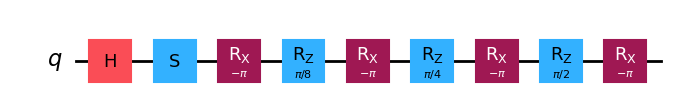

In [6]:
qc_a.draw(output="mpl")

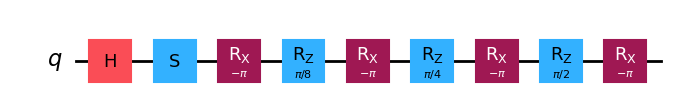

In [7]:
qc_b.draw(output="mpl")

In [8]:
result_a = job_a.result()
result_b = job_b.result()

s_a=Statevector.from_instruction(qc_a)
s_b=Statevector.from_instruction(qc_b)



In [9]:
print("Statevector for class A:")
s_a.draw(output="latex")

Statevector for class A:


<IPython.core.display.Latex object>

In [10]:

print("Statevector for class B:", s_b)

s_b.draw(output="latex")


Statevector for class B: Statevector([0.5879378 +0.39284748j, 0.39284748+0.5879378j ],
            dims=(2,))


<IPython.core.display.Latex object>

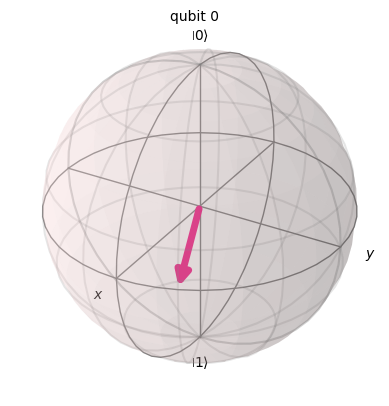

In [11]:

plot_bloch_multivector(s_a)

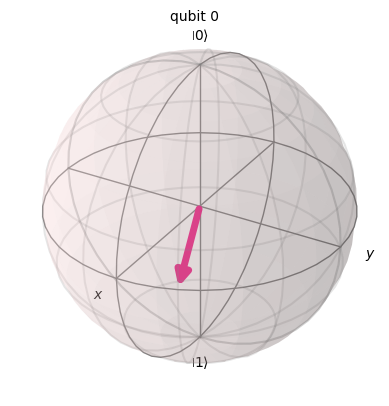

In [12]:
plot_bloch_multivector(s_b)

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Create a SWAP test circuit for two quantum circuits qc1 and qc2
def swap_test(qc1, qc2):
    q = QuantumRegister(3)
    c = ClassicalRegister(1)  # Register to store the measurement
    qc = QuantumCircuit(q, c)

    qc.compose(qc1, qubits=[1], inplace=True)
    qc.compose(qc2, qubits=[2], inplace=True)
    
    qc.h(0)
    
    # Apply the controlled-SWAP gate between qubit 1 and qubit 2, controlled by qubit 0
    qc.cswap(0, 1, 2)
    
    # Apply another Hadamard gate to the control qubit
    qc.h(0)
    
    # Measure the control qubit
    qc.measure(0, 0)
    
    return qc


In [14]:
def execute_test(qc):
    backend=QasmSimulator()
    transpiled_circ=transpile(qc,backend)
    job=backend.run(transpiled_circ,shots=1024)
    counts=job.result().get_counts()
    return counts.get('0',0)/1024

In [15]:
def cost_function(embeddings_a, embeddings_b, theta_params):
    cost = 0
    
    # Intra-class overlap within class A
    for i in range(len(embeddings_a)):
        for j in range(i, len(embeddings_a)):
            qc_a1 = quantum_embedding(embeddings_a[i], theta_params)
            qc_a2 = quantum_embedding(embeddings_a[j], theta_params)
            swap_circuit = swap_test(qc_a1, qc_a2)
            result = execute_test(swap_circuit)
            cost -= result  # Maximize intra-class similarity
    
    # Intra-class overlap within class B
    for i in range(len(embeddings_b)):
        for j in range(i, len(embeddings_b)):
            qc_b1 = quantum_embedding(embeddings_b[i], theta_params)
            qc_b2 = quantum_embedding(embeddings_b[j], theta_params)
            swap_circuit = swap_test(qc_b1, qc_b2)
            result = execute_test(swap_circuit)
            cost -= result
    
    # Inter-class overlap (between class A and class B)
    for i in range(len(embeddings_a)):
        for j in range(len(embeddings_b)):
            qc_a = quantum_embedding(embeddings_a[i], theta_params)
            qc_b = quantum_embedding(embeddings_b[j], theta_params)
            swap_circuit = swap_test(qc_a, qc_b)
            result = execute_test(swap_circuit)
            cost += result  # Minimize inter-class similarity

    return cost

In [16]:
from scipy.optimize import minimize

# Objective function for optimization
def objective(theta_params, embeddings_a, embeddings_b):
    return cost_function(embeddings_a, embeddings_b, theta_params)

# Example embeddings (replace with real data if necessary)
embeddings_a = np.linspace(-np.pi, np.pi, 5)  # Class A data
embeddings_b = np.linspace(-np.pi, np.pi, 5)  # Class B data

# Initial guess for theta parameters
theta_init = np.random.rand(3)

# Minimize the cost function using gradient descent (BFGS method)
result = minimize(objective, theta_init, args=(embeddings_a, embeddings_b), method='COBYLA')
optimized_theta = result.x

print("Optimized Parameters:", optimized_theta)

Optimized Parameters: [1.35489221 1.12066058 0.11133584]


In [17]:
final_cost = cost_function(embeddings_a, embeddings_b, optimized_theta)
print("Final Cost after Optimization:", final_cost)

Final Cost after Optimization: -4.9375


In [3]:
from qiskit.quantum_info import hellinger_distance,state_fidelity,hellinger_fidelity

In [19]:
def non_uniform_state():
    qc=QuantumCircuit(2)

    params=np.random.random(size=(3,))
    
    qc.h(0)
    qc.ry(params[0],1)
    qc.rz(params[1],0)

    qc.ry(params[2],1)
    qc.cx(0,1)

    
    return qc

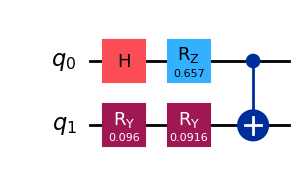

In [20]:
circ=non_uniform_state()
circ.draw(output="mpl")

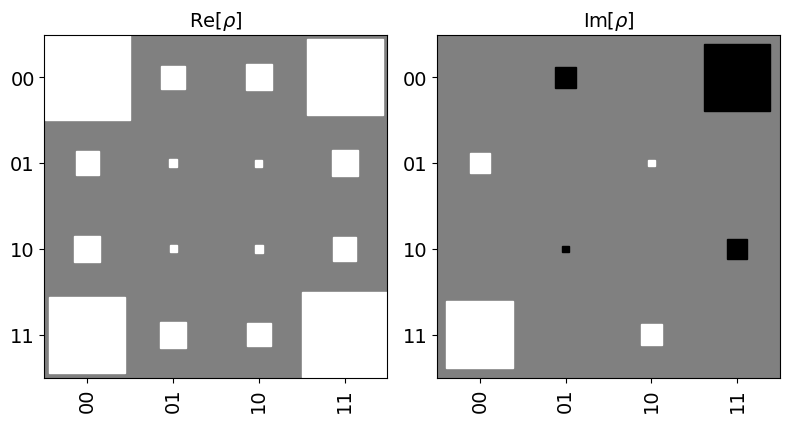

In [21]:
sv=Statevector(circ)
sv.draw(output="hinton")

In [22]:
def simulate_non_uniform(qc):
    circ.remove_final_measurements()
    circ.measure_all()
    backend=StatevectorSimulator()
    job=backend.run(qc,shots=1024)
    counts_sv=job.result().get_counts()

    return counts_sv

In [24]:
print(simulate_non_uniform(circ))
Result_dict["Qasm"]=simulate_non_uniform(circ)

{'00': 510, '11': 505, '01': 7, '10': 2}


In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

from qiskit_ibm_runtime import Session 

In [3]:
service=QiskitRuntimeService()


In [27]:
def real_backend(qc,backend):
    qc.remove_final_measurements()
    qc.measure_all()

    pm=generate_preset_pass_manager(backend=backend,optimization_level=1)
    transpiled_circ=pm.run(qc)

    with Session(service=service,backend=backend) as session:
        sampler=Sampler(mode=backend)
        job_sampler=sampler.run(pubs=[transpiled_circ],shots=1024)

        results=job_sampler.result()[0]

        counts=results.data.meas.get_counts()

        print("Counts from real backend: ", counts)
        return counts


In [121]:
real_backend(circ,backend)

Counts from real backend:  {'00': 399, '10': 130, '01': 121, '11': 374}


{'00': 399, '10': 130, '01': 121, '11': 374}

In [122]:
back_list=["ibm_kyiv","ibm_sherbrooke","ibm_brisbane"]
Result_dict={}

for i in back_list:
    backend=service.backend(i)
    count_backend=real_backend(circ,backend)

    Result_dict[i]=count_backend
print(Result_dict)

Counts from real backend:  {'00': 390, '11': 365, '10': 122, '01': 147}


In [1]:
Result_dict={}
Result_dict["ibm_kyiv"]={'00': 390, '11': 365, '10': 122, '01': 147}

In [28]:
Result_dict

{'ibm_kyiv': {'00': 390, '11': 365, '10': 122, '01': 147},
 'Qasm': {'00': 490, '11': 524, '10': 4, '01': 6}}

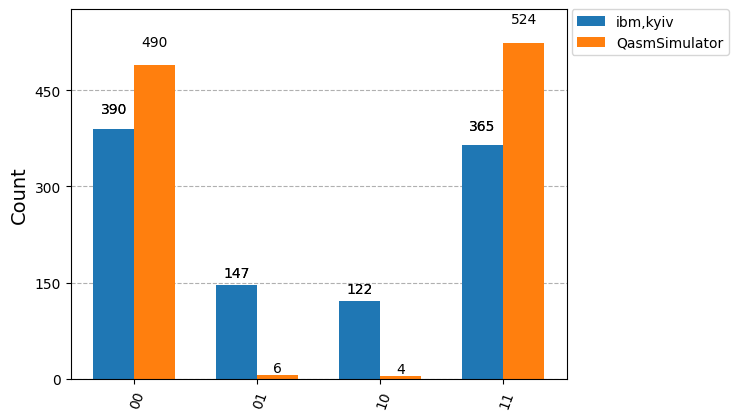

In [36]:
plot_histogram([Result_dict["ibm_kyiv"],Result_dict["Qasm"]],legend=["ibm,kyiv","QasmSimulator"])


In [4]:
from qiskit_aer import AerSimulator
import numpy as np 
import matplotlib.pyplot as plt
from qiskit.quantum_info import state_fidelity

**Preparing a Non-Uniform Quantum State**

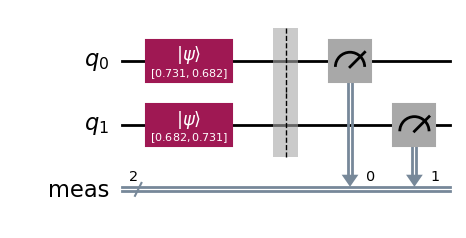

In [37]:
qc=QuantumCircuit(2)
seed=np.random.random()


alpha=np.sqrt(seed)
beta=np.sqrt(1-seed)

qc.initialize([alpha,beta],[0])
qc.initialize([beta,alpha],[1])

qc.measure_all()

qc.draw(output="mpl")

In [38]:
qc.remove_final_measurements()
zeros=Statevector.from_label("00")
sv_a=zeros.evolve(qc)

sv_a.draw(output="latex")

<IPython.core.display.Latex object>

In [18]:
service=QiskitRuntimeService()
backend=service.least_busy(operational=True,simulator=False)
pm=generate_preset_pass_manager(backend=backend,optimization_level=2)

opt_qc=pm.run(qc)

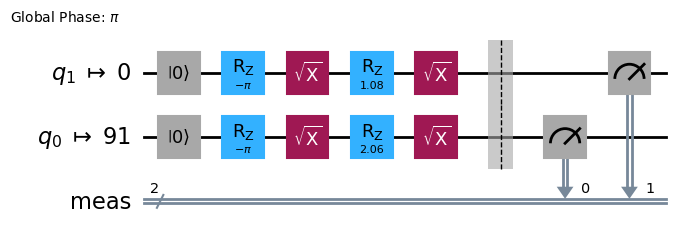

In [19]:
opt_qc.draw(output="mpl",idle_wires=False)

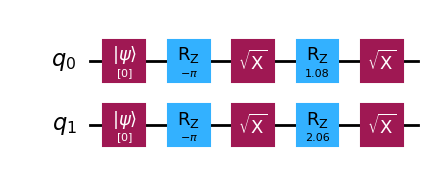

In [39]:
staged_circ=QuantumCircuit(2)

staged_circ.initialize(0,0)
staged_circ.initialize(0,1)
staged_circ.rz(-np.pi,0)
staged_circ.rz(-np.pi,1)

staged_circ.sx([0,1])
staged_circ.rz(1.08,0)
staged_circ.rz(2.06,1)

staged_circ.sx([0,1])

staged_circ.draw(output="mpl")

In [40]:
staged_circ.remove_final_measurements()

zeros=Statevector.from_label("00")

sv_b=zeros.evolve(staged_circ)

sv_b.draw(output="latex")

<IPython.core.display.Latex object>

In [42]:
print(f"Fidelity of Density Matrices: {state_fidelity(sv_a,sv_b)}")

Fidelity of Density Matrices: 0.8536382355604855


In [17]:
simulator=AerSimulator()

compiled_circ=transpile(qc,simulator)


job=simulator.run(compiled_circ,shots=512)
result=job.result().get_counts()

print(result)

{'10': 253, '11': 119, '00': 102, '01': 38}


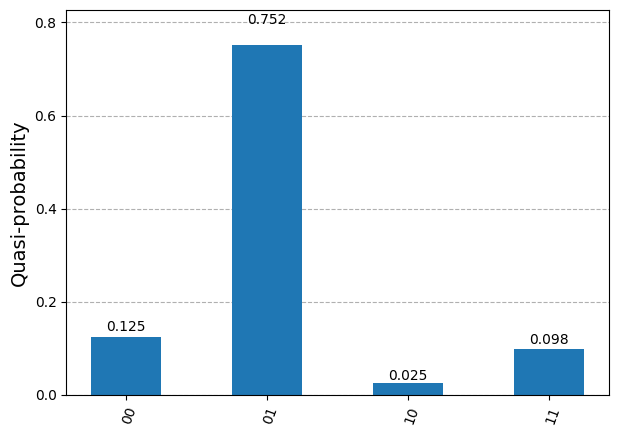

In [15]:
plot_distribution(result)

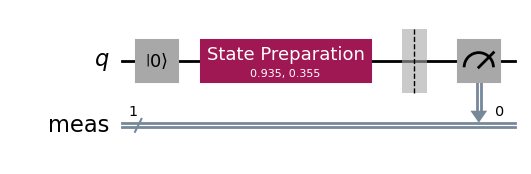

In [8]:
compiled_circ.decompose().draw(output="mpl")

In [9]:
count_sim=result 
shots = sum(count_sim.values())
prob_sim = {key: val / shots for key, val in count_sim.items()}


print("Simulator measurement probabilities (after evolution): \n", prob_sim)

Simulator measurement probabilities (after evolution): 
 {'0': 0.880859375, '1': 0.119140625}


In [17]:
backend=service.backend("ibm_kyiv")

print(f"Backend name: {backend.name}")

pm=generate_preset_pass_manager(backend=backend,optimization_level=3)

opt_qc=pm.run(qc)

Backend name: ibm_kyiv


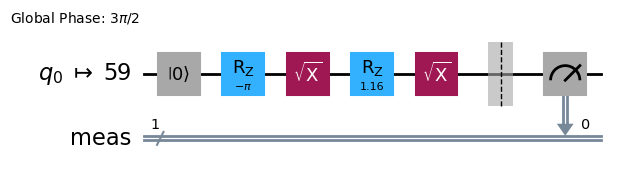

In [16]:
opt_qc.draw(output="mpl",idle_wires=False)

The above circuit is in terms of native gate. It differs from the $\ket{\psi}$ we prepared earlier.

In [17]:
shots=512
with Session(backend=backend,service=service) as session:
    sampler=Sampler(mode=backend)
    job=sampler.run([opt_qc],shots=shots)
    print(f"Backend name: {backend.name} and job id: {job.job_id()}")

    result=job.result()[0]
    counts_real=result.data.meas.get_counts()
prob_real = {key: val / shots for key, val in counts_real.items()}

Backend name: ibm_kyiv and job id: cvfkh7mz17rg008dan1g


In [10]:
job=service.job("cvfkh7mz17rg008dan1g")
result=job.result()[0]
counts_real=result.data.meas.get_counts()

prob_real = {key: val / shots for key, val in counts_real.items()}

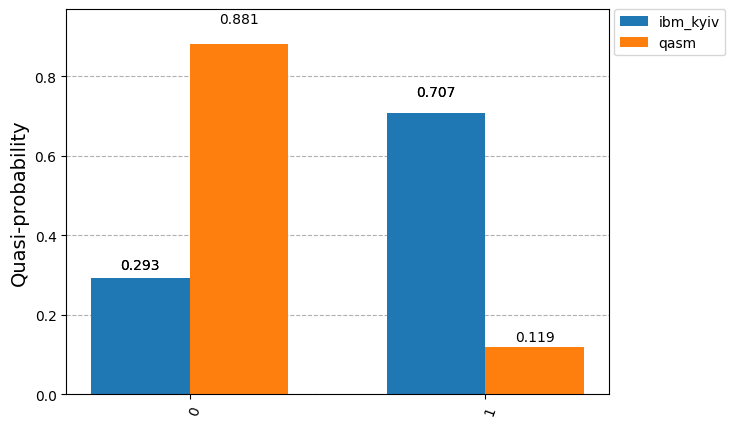

In [19]:
from qiskit.visualization import plot_distribution
from qiskit.quantum_info import state_fidelity,hellinger_distance,hellinger_fidelity

plot_distribution([counts_real,count_sim],legend=["ibm_kyiv","qasm"])

In [22]:
h_distance=hellinger_distance(count_sim,counts_real)
print(f"Hellinger Distance between real and simulator counts : {h_distance}")

Hellinger Distance between real and simulator counts : 0.44918269820064555


In [21]:
zeros=Statevector.from_label("0")
qc.remove_final_measurements()
sv=zeros.evolve(qc)

sv.draw(output="latex")

<IPython.core.display.Latex object>

In [13]:
import numpy as np
from qiskit.circuit.library import HGate, PhaseGate, RXGate, TdgGate, TGate, XGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    CXCancellation,
    InverseCancellation,
    PadDynamicalDecoupling,
)
from qiskit.quantum_info import hellinger_distance,hellinger_fidelity

In [14]:
from qiskit import QuantumCircuit,transpile 
from qiskit.quantum_info import state_fidelity,Statevector

import numpy as np
from qiskit_aer import AerSimulator,QasmSimulator,StatevectorSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler 
from qiskit_ibm_runtime import QiskitRuntimeService

In [15]:
def embedding(phi,theta_1,theta_2,theta_3):
    qc=QuantumCircuit(1)

    qc.s(0)
    qc.h(0)

    qc.rx(phi, 0)
    qc.rz(theta_1, 0)
    qc.rx(phi, 0)
    qc.rz(theta_2, 0)
    qc.rx(phi, 0)
    qc.rz(theta_3, 0)
    qc.rx(phi, 0)
    
    return qc

**Sample Circuit Construction**

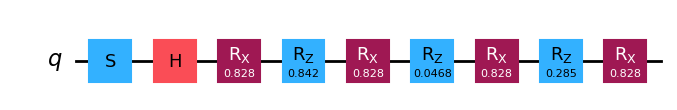

In [16]:
params=np.random.random(size=(4,))
qc=embedding(params[0],params[1],params[2],params[3])
qc.draw(output="mpl")

**Statevector Evolution**

In [17]:
zeros=Statevector.from_label("0")
sv_n=zeros.evolve(qc)

sv_n.draw(output="latex")

<IPython.core.display.Latex object>

**Statevector Simulation**

In [18]:
def get_statevector(qc):
    backend=StatevectorSimulator()
    job=backend.run(qc)
    result=job.result()
    sv=result.get_statevector()

    return sv

In [19]:
backend=StatevectorSimulator()

job=backend.run(qc)
result=job.result()

sv=result.get_statevector()
sv.draw(output="latex")


<IPython.core.display.Latex object>

In [20]:
theoretical_states = []
experimental_states = []

fidelities=[]

def calculate_fidelity(t_state,e_state):
    return state_fidelity(t_state,e_state)

In [21]:
t_state=get_statevector(qc)
print(t_state)

Statevector([ 0.04171918-0.89907557j, -0.24466298-0.36064201j],
            dims=(2,))


In [22]:
service=QiskitRuntimeService()
backend=service.least_busy(operational=True,simulator=False)
print(f"Backend name: {backend.name}")


Backend name: ibm_brisbane


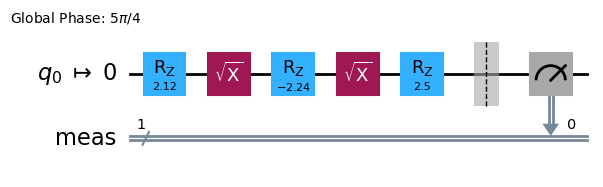

In [26]:
preset=generate_preset_pass_manager(backend=backend,optimization_level=1)

opt_qc=preset.run(qc)

opt_qc.draw(idle_wires=False,output="mpl")

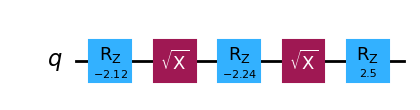

In [27]:
imitate=QuantumCircuit(1)

imitate.rz(-2.12,0)
imitate.sx(0)
imitate.rz(-2.24,0)
imitate.sx(0)
imitate.rz(2.5,0)

imitate.draw(output="mpl")

In [28]:
e_state=get_statevector(imitate)


x=calculate_fidelity(t_state,e_state)
print(f"Statevector Fidelity between Quantum Circuit and Transpiled Circuit:\n{x}")

Statevector Fidelity between Quantum Circuit and Transpiled Circuit:
0.9999998676048906


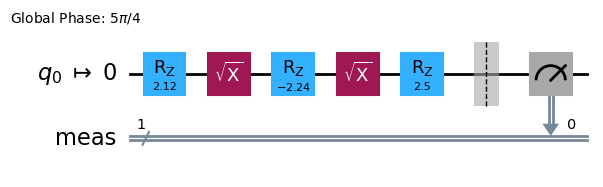

In [29]:
qc.remove_final_measurements()
qc.measure_all()

opt_qc=preset.run(qc)

opt_qc.draw(output="mpl",idle_wires=False)

In [30]:
simulator=QasmSimulator()
compiled=transpile(qc,simulator)
job_sim=simulator.run(compiled,shots=4096)

counts_sim=job_sim.result().get_counts()

print(f"Simulator Counts: {counts_sim}")

Simulator Counts: {'0': 3323, '1': 773}


In [31]:
sampler=Sampler(mode=backend)
pub=sampler.run([opt_qc])
print(f"Job id: {pub.job_id()}")
result=pub.result()[0]
counts=result.data.meas.get_counts()

print(f"Counts obtained from real backend: \n {counts}")

Job id: cvhh7f5z17rg008dgtdg
Counts obtained from real backend: 
 {'0': 3060, '1': 1036}


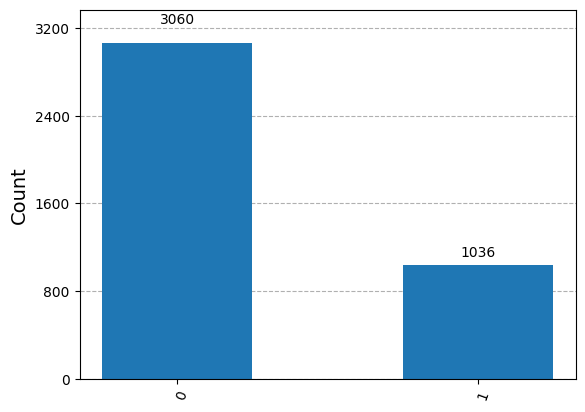

In [32]:
job_retrieved=service.job("cvhh7f5z17rg008dgtdg")

result=job_retrieved.result()[0]

counts=result.data.meas.get_counts()

plot_histogram(counts)

In [36]:
fidelity_score=hellinger_fidelity(counts_sim,counts)
print(counts_sim,"\n",counts)

print(f"Hellinger Fidelity between the two counts: {fidelity_score}")

{'0': 3323, '1': 773} 
 {'0': 3060, '1': 1036}
Hellinger Fidelity between the two counts: 0.9939932644214484


In [4]:
circuit=QuantumCircuit(127)

for i in range (circuit.num_qubits-2):
    circuit.sx(i)
    circuit.h(i)
    circuit.ccx(i,i+1,i+2)
circuit.measure_all()

In [9]:
service=QiskitRuntimeService()
backend=service.least_busy(operational=True,simulator=False)
pm=generate_preset_pass_manager(backend=backend,optimization_level=3)

opt_qc=pm.run(circuit)

In [10]:
sampler=Sampler(mode=backend)
pubs=sampler.run([opt_qc])

print(f"job id: {pubs.job_id()}")

result=pubs.result()[0]

counts=result.data.meas.get_counts()

plot_histogram(counts)

job id: cvgxd3cvawwg0089dw5g


In [3]:
service=QiskitRuntimeService()
backend=service.least_busy(operational=True,simulator=False)


result=service.job("cvgxd3cvawwg0089dw5g")

In [7]:
print(result)

<RuntimeJobV2('cvgxd3cvawwg0089dw5g', 'sampler')>


In [8]:
res=result.result()[0]
print(res)

PubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=4096, num_bits=127>)), metadata={'circuit_metadata': {}})


In [9]:
res.data.meas.get_counts()

{'1101001101110100101011001001010101011010100011101011100000100010000010100111100101100100110000100111110000100010000000001100100': 1,
 '0001000111111110001110010100001000001011100101101110101000000010100011110110101111101110110000011011010010010000011100111101010': 1,
 '1101100011101010100100001000000010001000011110110101111011000111000111100111100111110111101000111000110111110010110100101010100': 1,
 '1111100001111000100011111100011001111001100010001111101101110010110010101100100001100001011100000011000000110010001100011110110': 1,
 '0100111100001001000111010100000100100110010010111000000000100010101011100011100011010010000100001111011000110111101111010010110': 1,
 '0001010110001110110101100000111110000110111111010100100111000010100100000010111101100001100110100111000100001011101001011010000': 1,
 '0100100100100101100000110001101011111001001101010001111100000000111100000010110111100111010100000100100110110110110101110100110': 1,
 '00101101110000101110011110101111101110000010000100111